In [1]:
%%javascript

// Jupyter.utils.load_extensions('gist')

<IPython.core.display.Javascript object>

# General settings and loading of files

In [104]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm
from pandas import DataFrame as DF
from pandas import Series as S

% matplotlib inline
% load_ext autoreload
% autoreload 2
# % load_ext pep8_magic

pd.options.display.max_columns = 40  # Affy csv has 30 fields
mpl.rc_file_defaults()  # see .config/matplotlib/matplotlibrc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def hide_spines_and_ticks(ax, spines=["top", "right", "left"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)
        
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")

In [4]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

In [5]:
%run discriminate_present_vs_missing.py

GALANTER_CSV = '~/tesina/files/galanter_SNPs.csv'
LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!
# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

# lat = _create_Affymetrix_df(LAT1_CSV)

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [6]:
# Remove the biallelic SNP rs13327370
for panel in [galanter, missing]:
    panel.drop("rs13327370", inplace=True)

In [7]:
panels = {
    "GAL_Completo": galanter,
    "GAL_Affy": present,
    "GAL_Ausentes": missing,
}

res = {}
for label, panel in panels.items():
    count = len(panel)
    percentage = round(100 * count / len(galanter), 1)
    percentage = "{}%".format(percentage)
    
    res[label] = {
        "AIMs count": count,
        "AIMs percentage": percentage,
    }

pd.DataFrame(res).transpose().sort_index(ascending=False)

,AIMs count,AIMs percentage
GAL_Completo,445,100.0%
GAL_Ausentes,265,59.6%
GAL_Affy,180,40.4%


## Chequear de qué poblaciones ancestrales son los AIMs en GAL_Affy

In [8]:
res = []

for label, panel in panels.items():
    if "Ausentes" in label:
        continue
    series = panel['population'].value_counts()
    series.name = label
    series_percentage = (100 * series / len(panel)).apply(lambda x: "{}%".format(round(x, 1)))
    res.extend([series, series_percentage])

df = pd.concat(res, axis=1)
df

,GAL_Affy,GAL_Affy,GAL_Completo,GAL_Completo
AFR,62,34.4%,114,25.6%
EUR,71,39.4%,202,45.4%
NAM,47,26.1%,129,29.0%


En GAL_Affy observamos un aumento de la proporción de AIMs africanos respecto de los europeos, mientras que la proporción de AIMs americanos sigue igual. Esto podría tener por consecuencia, a primera vista, una sobreestimación del componente africano al usar GAL_Affy. No obstante, debe calcularse el LSBL acumulado de los SNPs de cada grupo y comparar *ese* valor.

In [9]:
from IPython.display import display, HTML

for label, panel in panels.items():
    print(label)
    html = panel.groupby("population").sum()[["LSBL(Fst)", "LSBL(In)"]].to_html()
    display(HTML(html))

GAL_Affy


,LSBL(Fst),LSBL(In)
population,,
AFR,39.605,23.662
EUR,28.278,15.926
NAM,26.967,15.953


GAL_Ausentes


,LSBL(Fst),LSBL(In)
population,,
AFR,32.824,19.813
EUR,49.582,28.069
NAM,47.528,28.010


GAL_Completo


,LSBL(Fst),LSBL(In)
population,,
AFR,72.429,43.475
EUR,77.860,43.995
NAM,74.495,43.963


Los AIMs que quedan en GAL_Affy siguen balanceados en cuanto a LSBL para determinar los componentes EUR y NAM. EL valor de LSBL queda relativamente más alto que en GAL_Completo, por lo que debemos estar atentos a posibles diferencias en resultado entre GAL_Affy y GAL_Completo que afecten específicamente al componente ancestral africano --en particular, que lo sobreestimen.

Sin embargo, esto no parece ser un problema en nuestros resultados, al menos para las muestras de 1000 Genomas utilizadas. La comparación de proporción de ancestría africana estimada para las diferentes poblaciones parece mantenerse igual entre ambos paneles, a pesar de esa reducción diferencial de AIMs. Con todo, este _caveat_ quedará para futuros usos de GAL_Affy.

## Comparar Galanter.bed con Galanter de PLoS

In [10]:
galanter_remapped = pd.read_csv("/home/juan/tesina/files/galanter.GRCh38.p6.bed", sep="\t",
                               names=['chr', 'position', 'pos_to', 'id'], comment="#", skiprows=3,
                               usecols=['chr', 'position', 'pos_to', 'id'])

# The online remapping generated weird chromosomes
weird_chromosomes = galanter_remapped["chr"].str.contains("_")
galanter_remapped.drop(galanter_remapped[weird_chromosomes].index, inplace=True)

galanter_remapped['chr'] = galanter_remapped['chr'].str.replace("chr", "").astype(int)
galanter_remapped.drop_duplicates("id", keep="last", inplace=True)
galanter_remapped.set_index('id', inplace=True)

In [11]:
galanter_plos = galanter[['chr', 'position']]

In [12]:
import re

galanter_dbSNP = pd.read_csv("/home/juan/tesina/files/galanter_rsIDs_dbSNP",
                             names=['id', 'source', 'chr', 'pos', 'pos_to'], skiprows=1).set_index('id')
take_these_out = galanter_dbSNP.chr.str.contains('HSCHR')
galanter_dbSNP = galanter_dbSNP[~take_these_out]
galanter_dbSNP['chr'] = galanter_dbSNP['chr'].astype(int)
galanter_dbSNP = galanter_dbSNP.drop_duplicates()

In [13]:
galanter.index.difference(galanter_remapped.index)

Index([], dtype='object')

Debería usar las posiciones de el build `GRCh38.p6` en `galanter_remapped`, pero no están todas puede ser? Chequear

In [14]:
print(galanter.index.difference(galanter_remapped.index))
print(galanter_remapped.index.difference(galanter.index))

Index([], dtype='object')
Index([], dtype='object')


# Chromosomal distribution of the AIMs

* Chromosome lengths were taken from:

[Assembly Statistics for GRCh38.p6 Release date: December 23, 2015](http://www.ncbi.nlm.nih.gov/projects/genome/assembly/grc/human/data/)

* Centromere ranges were taken from the FTP server: 

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA_000001405.21_GRCh38.p6/GCA_000001405.21_GRCh38.p6_assembly_structure/genomic_regions_definitions.txt



In [15]:
chrom_lengths = pd.read_csv("/home/juan/tesina/files/GRCh38.p6_genome_stats.csv",
                            index_col="chr", usecols=["chr", "total length"])
chrom_lengths.drop(["X", "Y"], inplace=True)

regions = pd.read_csv("/home/juan/tesina/files/GRCh39.p6_genomic_regions_definitions.txt",
                      sep="\t", index_col="#region_name", usecols=["#region_name", "start", "stop"])

centromers = regions.loc[[i for i in regions.index if "CEN" in i]]
centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
centromers = centromers.set_index("chromosome").drop(["X", "Y"])
centromers.index.name = "chr"

genome = centromers.join(chrom_lengths)
genome.columns = ["centromere_start", "centromere_end", "chr_length"]
genome.index = [int(i) for i in genome.index]

/home/juan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Distancias entre los AIMs por cromosoma

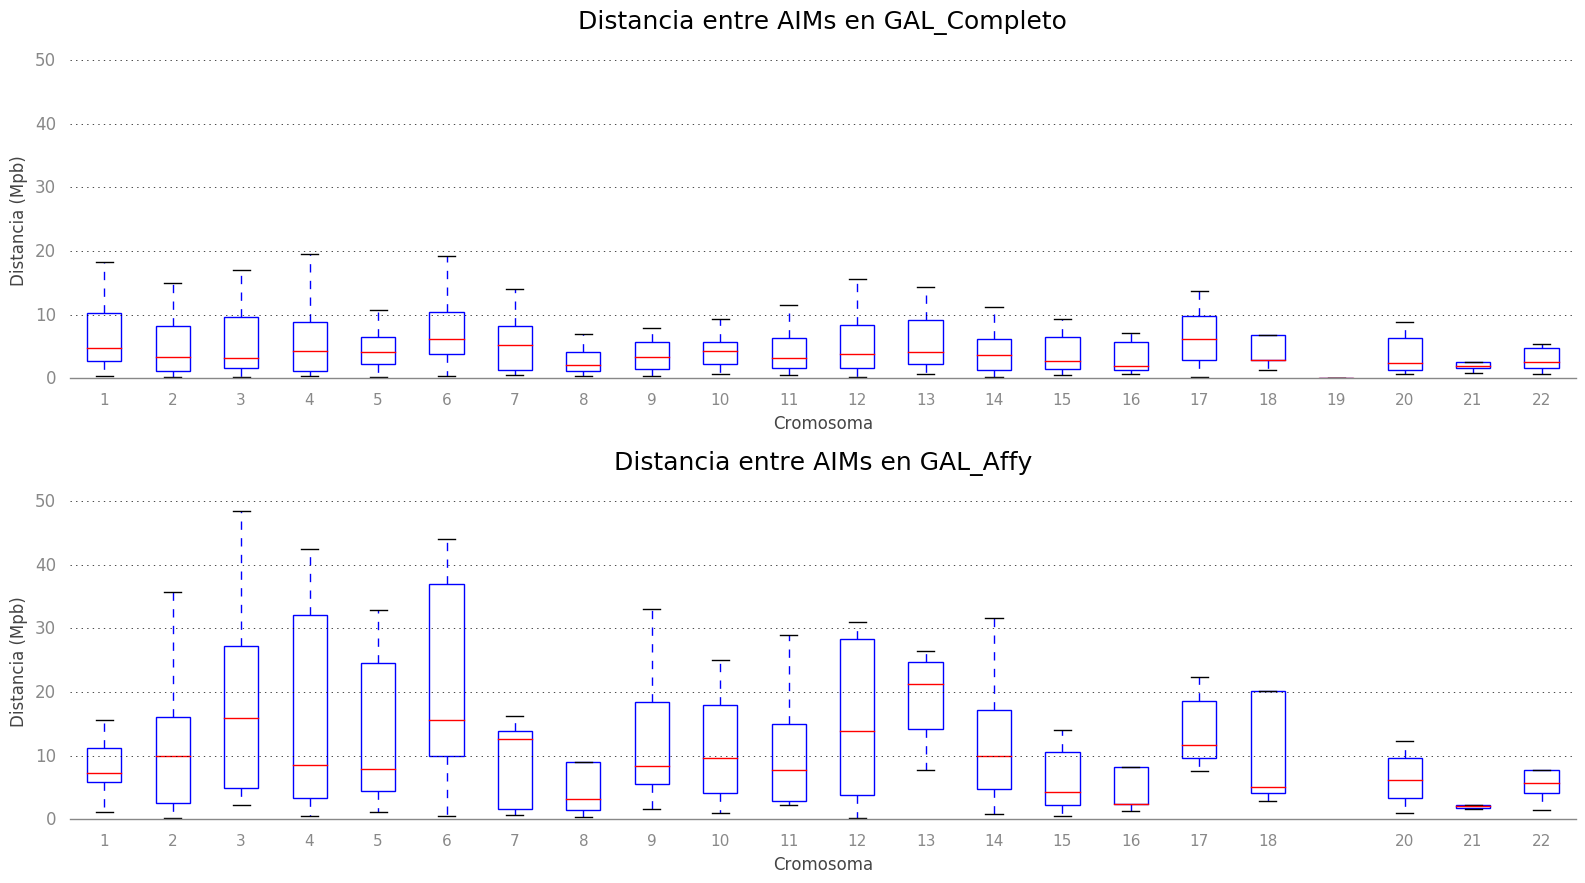

In [16]:
% run data_munging/distances.py
% run SNP_distances_plots.py

ax1 = plt.subplot(211)
ax1 = distances_boxplot(galanter, genome, ax=ax1,
                        title=r"Distancia entre AIMs en GAL_Completo")

ax2 = plt.subplot(212, sharey=ax1)
ax2 = distances_boxplot(present, genome, ax=ax2,
                        title=r"Distancia entre AIMs en GAL_Affy")

hide_spines_and_ticks(ax1)
hide_spines_and_ticks(ax2)

plt.tight_layout()
plt.show()

In [17]:
distances = {}

for panel_name, panel in {"GAL_Completo": galanter, "GAL_Affy": present}.items():
    temp_dict = snp_distances_per_chromosome(panel, genome)

    for chromosome, chr_distances in temp_dict.items():
        temp_dict[chromosome] = (np.mean(chr_distances),
                                 np.std(chr_distances),
                                 np.median(chr_distances))
    
    distances[panel_name] = pd.DataFrame(temp_dict).T.astype(int)
    distances[panel_name].columns = ["mean", "std", "median"]

distances_df = distances["GAL_Completo"].join(distances["GAL_Affy"], rsuffix="_Affy")

# Pensé que representarlo en una tabla sería mejor, pero tal vez no.
# El boxplot es más informativo más rápidamente, y más intuitivo.
# distances_df

El archivo `galanter.bed` con las posiciones de los AIMs reportadas por Galanter *et al.* correspondía al genoma de referencia `GRCh37.p5`. La conversión al build `GRCh38.p6` fue realizada online con la herramienta de *remapping* provista por NCBI Genome Tools, de modo que fueran coherentes con la información sobre longitud total de los cromosomas y rango de los centrómeros.

http://www.ncbi.nlm.nih.gov/genome/tools/remap

In [18]:
galanter["pos"] = galanter_remapped["position"]

In [19]:
def pop_counts(df):
    return df.groupby(['chr', 'population']).size().unstack().fillna('>> 0 <<')

df = pd.merge(pop_counts(galanter), pop_counts(present),
         left_index=True, right_index=True,
         suffixes=['_TOTAL', '_IN'])

df.columns = pd.MultiIndex.from_product([['$GALANTER_{TOTAL}$', '$GALANTER_{IN}$'],
                                         ['AFR', 'EUR', 'NAM']])
df

$GALANTER_{TOTAL}$         $GALANTER_{IN}$                  
                   AFR EUR NAM             AFR      EUR      NAM
chr                                                             
1                    8  15   4               5        4        2
2                   11  21  12               7        9        4
3                    6  16  12               2        4        3
4                    8  12   7               5        5        2
5                    8   8   9               5        1        2
6                    7   7   7               5        1        1
7                    7  10   4               5        2        3
8                    5  10   8               2        3        3
9                    1  11   7               1        6        1
10                   6  13   8               3        5        3
11                   9  12   7               6        3        4
12                   6  13   3               2        3  >> 0 <<
13                   4   8   5               1        3        1
14                   7   6   9               3        3        2
15                   4  12   4               3        7        2
16                   6   8   2               3        4        1
17                   5   5   2               1        3        1
18             >> 0 <<   5   3         >> 0 <<        2        2
20                   1   5   7         >> 0 <<        2        4
21                   4   2   3               2        1        3
22                   1   2   6               1  >> 0 <<        3

**DISCUSIÓN**

La reducción de AIMs en GALANTER-IN determina que ciertos cromosomas no tengan ningún AIM de una población determinada:

- En el cromosoma 12 se perdieron los 3 AIMs de NAM.
- En el cromosoma 20 se perdió el único AIM de AFR.
- En el cromosoma 22 se perdieron los 2 AIMs de EUR.

En realidad esto no importa demasiado, ya que estamos haciendo inferencia de ancestría global, no local.

# Generate CONTROL PANELS of random SNPs

- Extract the **same amount * factor** of SNPs per chromosome as Galanter has,
  with some min space between them.
- The SNPs to extract should all be present in LAT-1

In [20]:
galanter.groupby("chr").size().to_csv("data/chr_SNP_count_in_galanter")

In [21]:
cols = ["dbSNP RS ID", "Chromosome", "Position End", "Minor Allele Frequency"]
lat = pd.read_csv("/home/juan/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv", comment="#",
                  index_col="dbSNP RS ID", usecols=cols)
lat.drop(["---"], inplace=True)  # SNPs with no rs ID
lat["Position End"] = lat["Position End"].astype(int)
lat.sort_values(by=["Chromosome", "Position End"], inplace=True)

In [22]:
# === WARNING ====
# Running this cell took 26 minutes. I already got the spn_lists written to files
# in the following cell, so there's no reason to run this again.


# from math import floor
# import time

# control_panels = {}

# for exponent in [0, 1, 2]:
#     factor = 10 ** exponent
#     print("== Control Panel x {} ==\n".format(factor))
#     number_of_snps_to_take = galanter.groupby("chr").size() * factor

#     control_panels[factor] = {}
    
#     for chromosome, snps_number in number_of_snps_to_take.items():            
#         this_chromosome = lat[lat["Chromosome"] == str(chromosome)]
#         positions = this_chromosome["Position End"]
        
#         # I will maximize the distance between indices of the positions list
#         # as a proxy to maximize the distance between the positions in the chromosome ;)
#         distance_between_indices = floor(len(positions) / snps_number)
#         positions_to_take = [positions[n * distance_between_indices]
#                              for n in np.arange(snps_number)]

#         indices_to_take = positions[positions.isin(positions_to_take)].index.unique()
#         control_panels[factor][chromosome] = indices_to_take
        
#         print("[{}] Chr {}, {} to take, {} were taken".format(time.strftime("%H:%M:%S"),
#                                                               chromosome, snps_number,
#                                                               len(control_panels[factor][chromosome])))

In [23]:
# import os

# for factor, snp_dic in control_panels.items():
#     for chromosome, snp_list in snp_dic.items():
#         basedir = "/home/juan/tesina/files"
#         fn = "control_panel_x{}.chr_{}.snp_list_to_take_{}".format(factor, chromosome, len(snp_list))
#         with open(os.path.join(basedir, fn), "w") as dest_file:
#             dest_file.write("\n".join(snp_list) + "\n")

^ With the generated snp_lists per chromosome, we need to extract those variants
from the 1000 Genomes `*.vcf` files, using PLINK.

The script used with this purpose is `/home/juan/tesina/1000 ... /create_control_panels.sh`

# Read the Control Panels

In [24]:
control_genotypes = {}


# Maybe I shouldn't create the DataFrames yet... not to hog the RAM

for factor in ["1", "10", "100"]:
    fn = "/home/juan/tesina/1000Genomes_data/new_control_panels/cpx{}.ALL.parsed.traw".format(factor)
    control_genotypes[factor] = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
    control_genotypes[factor].index = [sample.split("_")[0]
                                       for sample in control_genotypes[factor].index]

In [25]:
control_positions = {}

for factor in ["1", "10", "100"]:
    rs_ids = control_genotypes[factor].columns
    df = lat.loc[rs_ids][["Chromosome", "Position End"]]
    df.columns = ["chr", "position"]
    df["position"] = df["position"].astype(int)
    df["chr"] = df["chr"].astype(int)
    df.index.name = "rsID"
    control_positions[factor] = df

# Plot the distribution of AIMs per chromosome

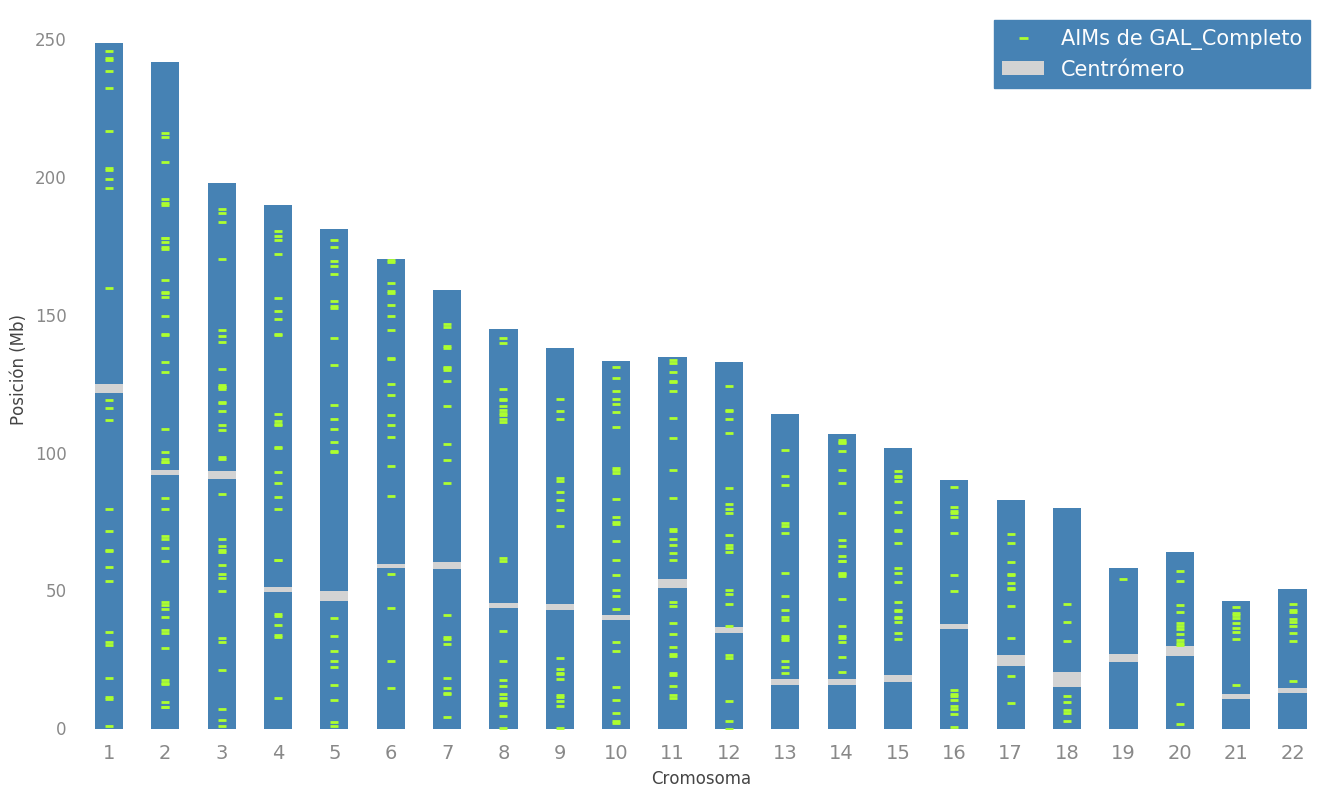

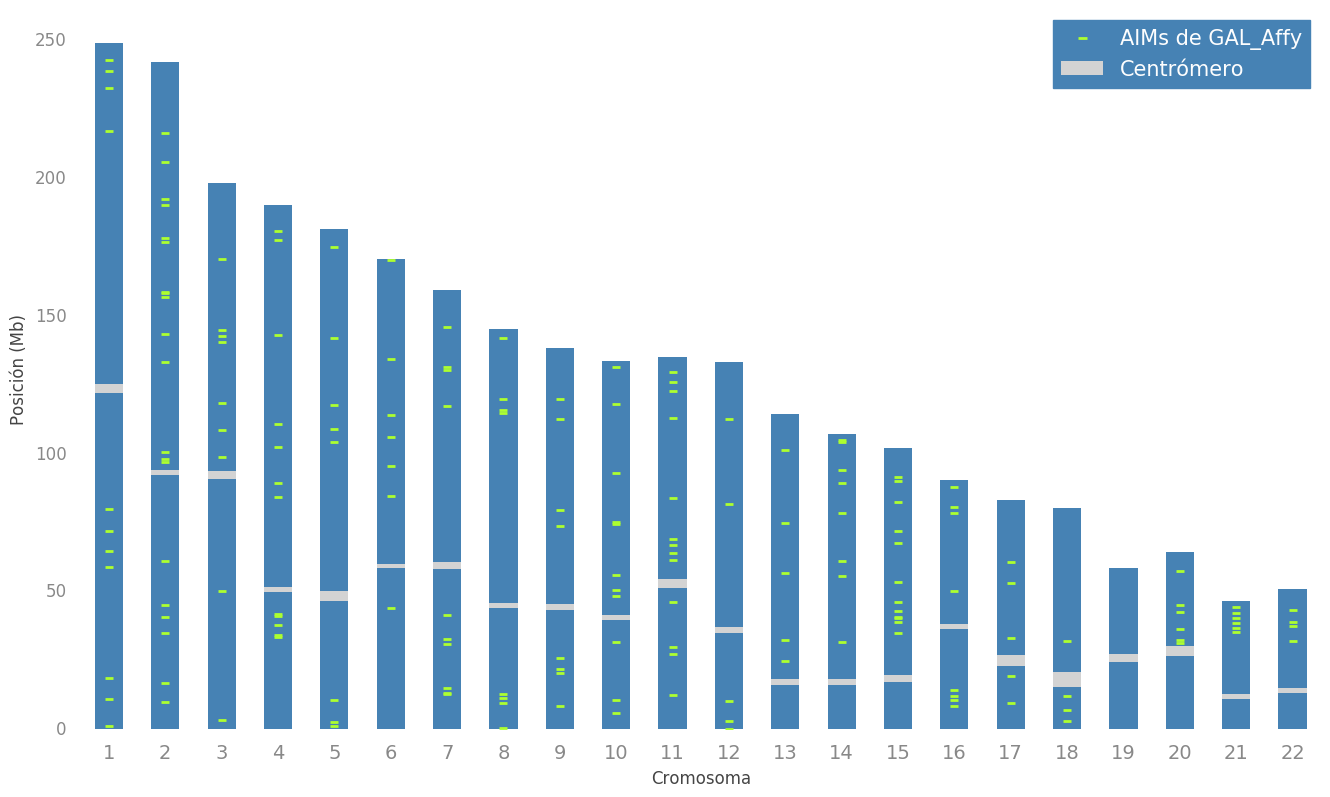

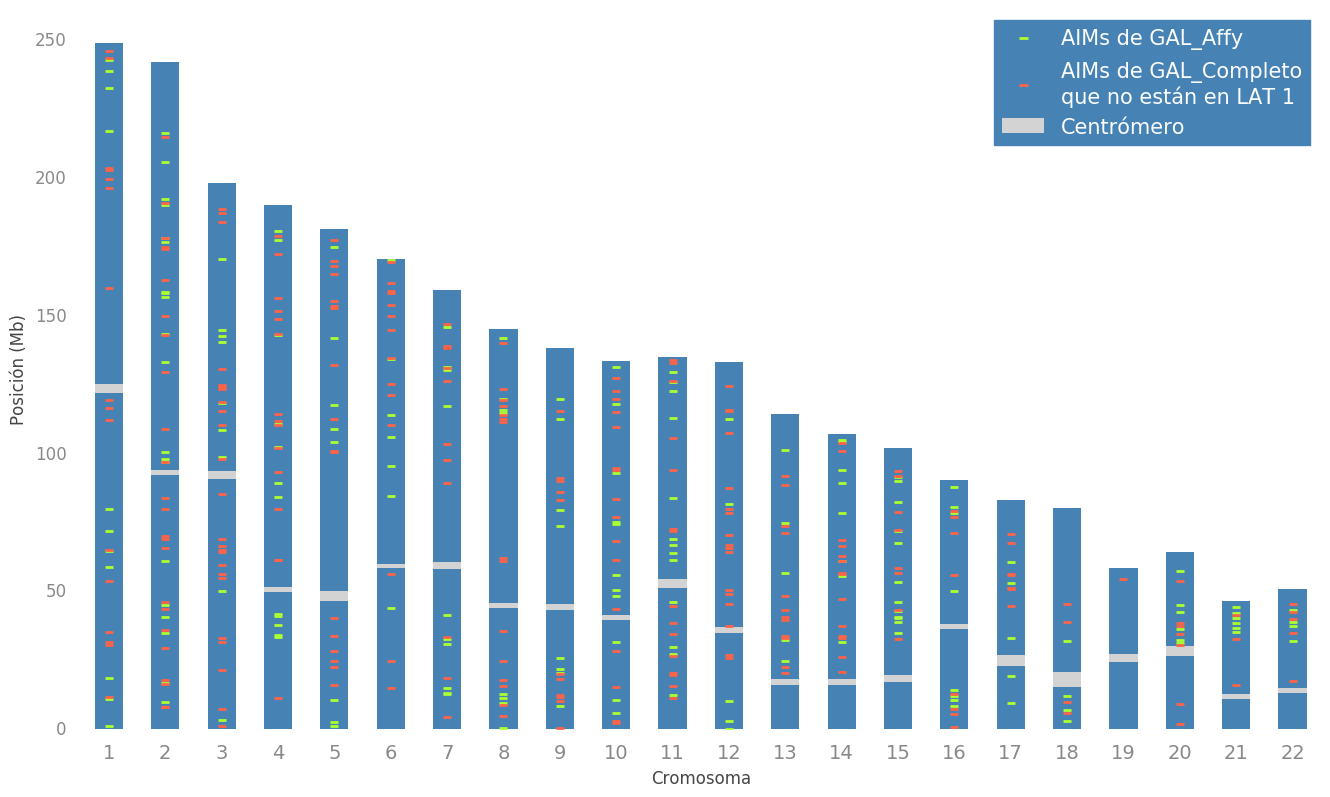

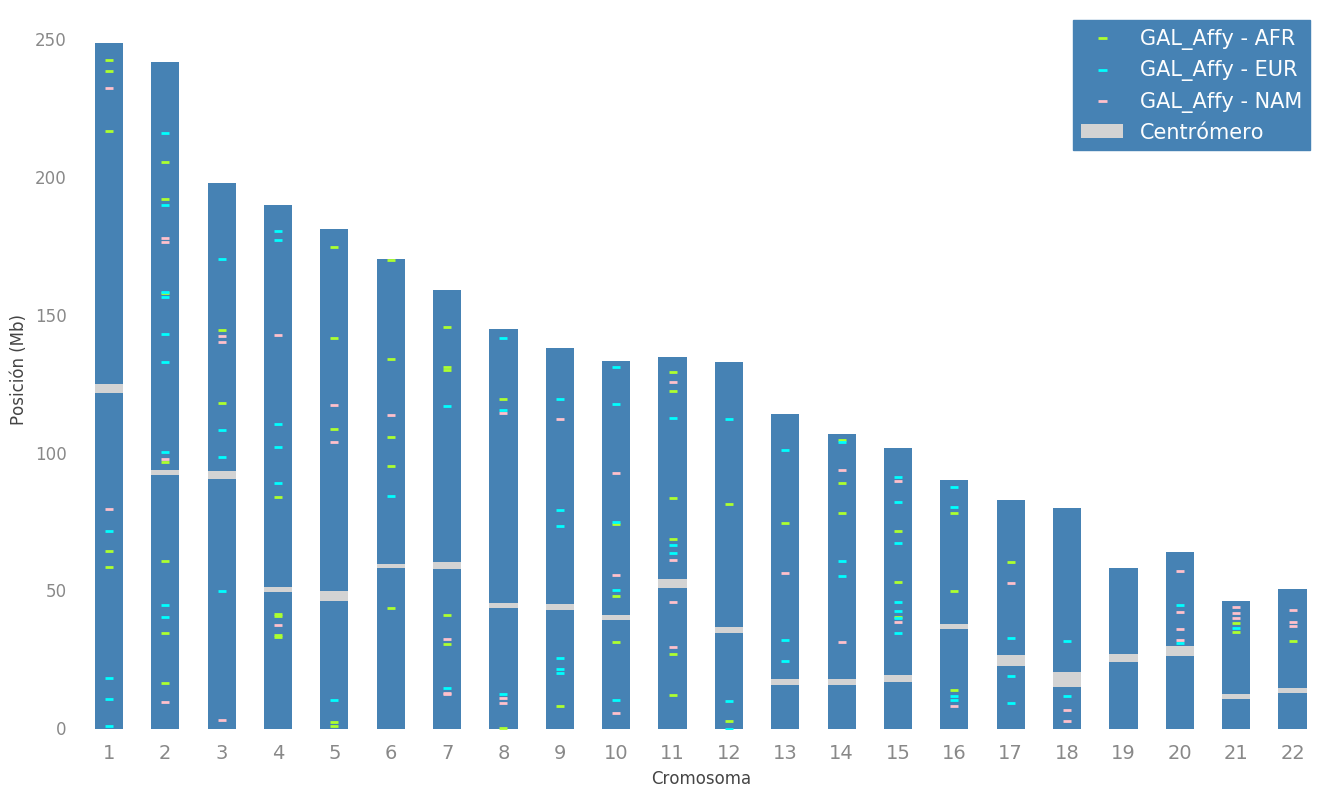

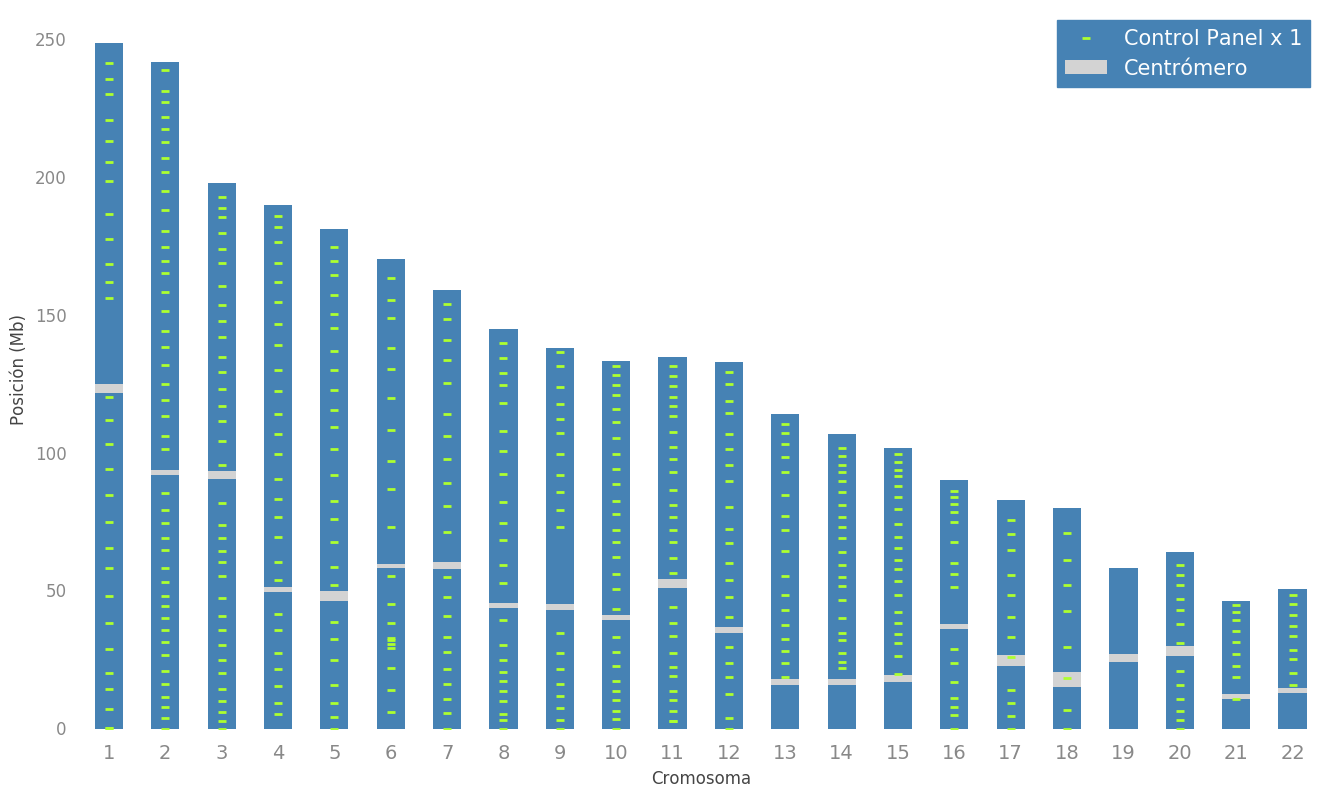

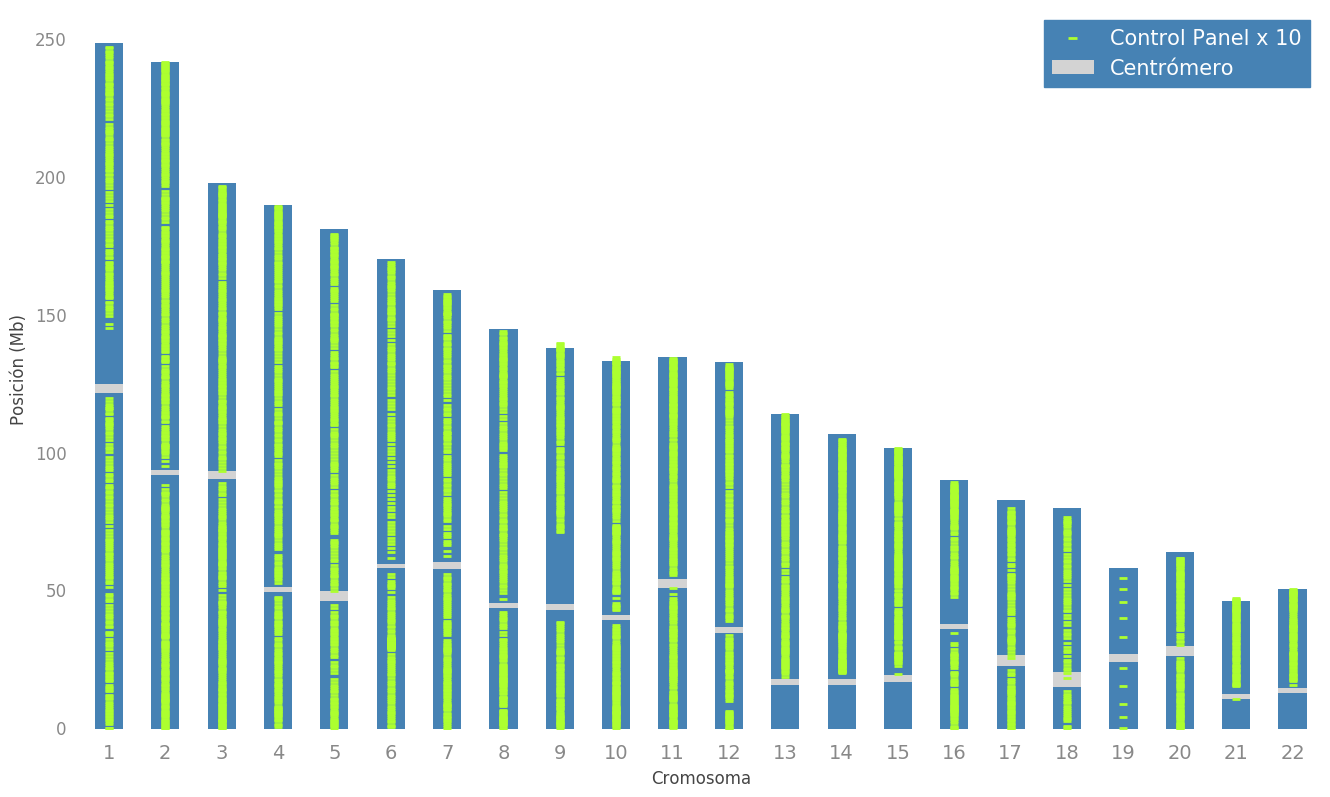

In [39]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict

markersize = 40

plot_settings = [
    # GAL_Completo
    OrderedDict([
        ('AIMs de GAL_Completo',
         {'df': galanter,
          'marker': '_', 'color': 'greenyellow', 's': markersize}),
    ]),
    
    # GAL_Affy
    OrderedDict([
        ('AIMs de GAL_Affy',
         {'df': present,
          'marker': '_', 'color': 'greenyellow', 's': markersize}),
    ]),
    
    # GAL_Completo vs. GAL_Affy
    OrderedDict([
        ('AIMs de GAL_Affy',
         {'df': present,
          'marker': '_', 'color': 'greenyellow', 's': markersize}),
        ('AIMs de GAL_Completo\nque no están en LAT 1',
         {'df': missing,
          'marker': '_', 'color': 'tomato', 's': markersize}),
    ]),
    
    # GAL_Affy different ancestries
    OrderedDict([
        ('GAL_Affy - AFR',
         {'df': present[present.population == "AFR"],
          'marker': '_', 'color': 'greenyellow', 's': markersize}),

        ('GAL_Affy - EUR',
         {'df': present[present.population == "EUR"],
          'marker': '_', 'color': 'cyan', 's': markersize}),

        ('GAL_Affy - NAM',
         {'df': present[present.population == "NAM"],
          'marker': '_', 'color': 'pink', 's': markersize}),
    ]),
    
    # Control Panel x 1
    OrderedDict([
        ('Control Panel x 1',
         {'df': control_positions["1"],
          'marker': '_', 'color': 'greenyellow', 's': markersize}),
    ]),

    # Control Panel x 10
    OrderedDict([
        ('Control Panel x 10',
         {'df': control_positions["10"],
          'marker': '_', 'color': 'greenyellow', 's': markersize}),
    ]),
]

for plot_data in plot_settings:
    chromosomes_with_SNPs_plot(genome, plot_data)
    plt.show()

# Traer la data de 1000Genomes para estos SNPs

In [27]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [28]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

In [29]:
%run read_samples_data.py

sample_populations_file = "/home/juan/tesina/1000Genomes_data/original-1000Genomes-files/" + \
                          "integrated_call_samples_v3.20130502.ALL.panel"
df_1000G_sample_populations = read_samples_data(sample_populations_file)

In [30]:
%run read_1000genomes_data.py
%run helpers/data_munging_functions.py

import itertools
# from glob import glob
from os.path import isfile


# vcf_filenames = glob("/home/juan/tesina/1000G_analysis/galanter_1000Genomes.vcf")
vcf_filename = "/home/juan/tesina/1000G_analysis/galanter_1000Genomes.vcf"
df_1000G_SNPs_dumpfile = "dumpfiles/1000G_SNPinfo_dataframe.csv"
df_1000G_genotypes_dumpfile = "dumpfiles/1000G_genotypes_dataframe.csv"

if not isfile(df_1000G_SNPs_dumpfile):
    # records = [_vcf_records(vcf_filename) for vcf_filename in vcf_filenames]
    records = _vcf_records(vcf_filename)
    # records = itertools.chain.from_iterable(records)  # Flattens list of lists
    records_as_dictionaries = [_vcf_record_to_dict(r) for r in records]

    # Clean up 1000genomes data
    df_1000G_SNPs = pd.DataFrame(records_as_dictionaries).set_index('ID')
    df_1000G_SNPs = df_1000G_SNPs.dropna(axis=1)
    df_1000G_SNPs = df_1000G_SNPs.drop(['FILTER', 'alleles'], axis=1)
    df_1000G_SNPs = remove_unkown_snp_subtypes(df_1000G_SNPs)
    df_1000G_SNPs = remove_unnecessary_lists_from_df(df_1000G_SNPs)

    # Get sample genotypes
    frames = [pd.DataFrame(dict(genotypes), index=[rs])
              for rs, genotypes in df_1000G_SNPs['sample_genotypes'].iteritems()]
    df_1000G_genotypes = pd.concat(frames).transpose()
    df_1000G_genotypes.to_csv(df_1000G_genotypes_dumpfile)

    # Remove big unnecessary field after exporting its data to 'samples_genotypes'
    df_1000G_SNPs = df_1000G_SNPs.drop('sample_genotypes', axis=1)
    df_1000G_SNPs.to_csv(df_1000G_SNPs_dumpfile)

df_1000G_SNPs = pd.read_csv(df_1000G_SNPs_dumpfile, index_col='ID')
df_1000G_genotypes = pd.read_csv(df_1000G_genotypes_dumpfile, index_col=0)

In [31]:
%run population_names.py

dumpfile = "dumpfiles/population_names.csv"
df_1000G_population_names = create_population_names_df(dumpfile)

In [32]:
def whois(pop_code):
    return df_1000G_population_names.loc[pop_code]['Population Description']

whois('ACB')

'African Caribbeans in Barbados'

In [33]:
from os.path import isfile

df = df_1000G_genotypes
df2 = pd.DataFrame(index=df.index)

alleles_dumpfile = 'dumpfiles/1000G_genotypes_alleles_dataframe'

if not isfile(alleles_dumpfile):
    def genotype_code_to_alleles(code, ref, alt):
        if code == 0:
            alleles = (ref, ref)
        elif code == 1:
            alleles = (ref, alt)
        elif code == 2:
            alleles = (alt, alt)
        else:
            raise ValueError("I don't know genotype '{}'".format(code))

        return ''.join(alleles)

    for i, (rs, genotypes) in enumerate(df.iteritems()):
        ref, alt = df_1000G_SNPs.loc[rs][['REF', 'ALT']]
        df2[rs] = genotypes.apply(genotype_code_to_alleles, args=(ref, alt))

    df2.to_csv(alleles_dumpfile)

df_1000G_genotypes_alleles = pd.read_csv(alleles_dumpfile, index_col=0)
df_1000G_genotypes_alleles.head(2)

,rs10751867,rs4881046,rs907687,rs4747860,rs1326207,rs4749305,rs3123687,rs4948800,rs709616,rs3810947,rs2795918,rs7911953,rs10997469,rs11000445,rs7080350,rs7097617,rs7902158,rs2245251,rs11186960,rs4244304,...,rs10111852,rs7048037,rs1500318,rs1535661,rs10756267,rs791654,rs10810942,rs10811305,rs3780827,rs7864029,rs1231375,rs12380601,rs7851160,rs4146171,rs4877824,rs10746839,rs1980889,rs3001115,rs10981899,rs2809393
HG00096,TT,TA,TT,CT,AA,AA,CG,CC,GG,GG,TT,TT,CT,TT,GA,AG,AG,CT,CA,CT,...,CC,GG,CC,AA,GG,AA,GA,GC,CC,GG,CC,GA,AA,TC,AG,GG,TT,CC,GG,TC
HG00097,CT,AA,TT,CC,AA,AA,GG,CC,GG,GA,TT,TT,CC,TT,AA,AG,AG,CT,CA,CC,...,TT,GG,CC,AA,GG,AA,GG,GG,CG,GG,CC,AA,AA,CC,AG,GG,TC,TC,GG,CC


## Compute MAF by Population (1000 Genomes data)

I use both `plink` and `pandas` for this computation. `pandas` to make the `.fam` files
with either population or subpopulation names in the family field. `plink` to
compute the frequencies using each of the `.fam` files.

In [43]:
# == NOTE ==
# This was used to generate different .fam files (with population and superpopulation data)
# so that plink could generate frequencies relative to those groups.
# It's already done now, results are read in the next cell.

# basedir = "/home/juan/tesina/1000Genomes_data/galanter-extracted-SNPs-from-1000Genomes/"
# fam_file_fields = ["fam", "sample", "father", "mother", "sex", "phenotype"]

# for panel_name in ["gal_completo", "gal_affy"]:

#     # Read original .fam with no populations info
#     fn = basedir + "{}.fam".format(panel_name)
#     nofam = pd.read_csv(fn, engine="python", sep="\s*", names=fam_file_fields,
#                         index_col="sample")

#     # Write the populations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_sample_populations["population"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.populations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

#     # Write the superpopulations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_sample_populations["super_population"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.superpopulations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

Between the previous cell (`.fam` files generation) and the next cell (reading of the `.frq.strat` files),
plink was run to compute the frequencies per population.

Check the bash script `/home/juan/tesina/1000Genomes_data/galanter-extracted-SNPs-from-1000Genomes/2_compute_freqs.sh`

In [96]:
basedir = "/home/juan/tesina/1000Genomes_data/galanter-extracted-SNPs-from-1000Genomes"

mafs = {"per_population": {}, "per_superpopulation": {}}

for panel_name in ["GAL_Completo", "GAL_Affy"]:
    fn = "{}/{}.populations.frq.strat".format(basedir, panel_name.lower())
    df = pd.read_csv(fn, engine="python", sep="\s*")
    df = df.pivot_table(values="MAF", index="SNP", columns="CLST")
    df = df.applymap(lambda freq: 1 - freq if freq > 0.5 else freq)
    mafs["per_population"][panel_name] = df

    fn = "{}/{}.superpopulations.frq.strat".format(basedir, panel_name.lower())
    df = pd.read_csv(fn, engine="python", sep="\s*")
    df = df.pivot_table(values="MAF", index="SNP", columns="CLST")
    df = df.applymap(lambda freq: 1 - freq if freq > 0.5 else freq)
    mafs["per_superpopulation"][panel_name] = df

/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [48]:
## == NOTE ==
## This was how I previously computed --manually-- the MAFs per population
## PLINK already does it, so this code is a fossil. I kept it just in case for now.

# def maf_by_population_from_genotypes(df_genotypes, df_populations, dumpfile):

#     if not isfile(dumpfile):
#         freq_by_population = defaultdict(dict)

#         for rs, genotypes in df_genotypes.iteritems():
#             ref_alleles_count = defaultdict(lambda: 0)
#             total_alleles_count = defaultdict(lambda: 0)
#             ref = df_genotypes.iloc[1, 1][0]  # Arbitrarily pick a ref allele for the count

#             for sample, genotype in genotypes.iteritems():
#                 # genotype is a 'TT' or 'TC' like string, transform it to a number of ref_alleles
#                 ref_count = genotype.count(ref)
#                 try:
#                     population = df_populations.loc[sample].population
#                     super_population = df_populations.loc[sample].super_population
#                 except KeyError:
#                     continue
#                 ref_alleles_count[population] += ref_count
#                 ref_alleles_count[super_population] += ref_count
#                 total_alleles_count[population] += 2
#                 total_alleles_count[super_population] += 2

#             for population, ref_alleles in ref_alleles_count.items():
#                 freq_by_population[rs][population] = ref_alleles / total_alleles_count[population]

#         freqs = pd.DataFrame(dict(freq_by_population)).transpose()
#         mafs = freqs.applymap(lambda freq: min(freq, 1 - freq))
#         mafs.to_csv(dumpfile)

#     return pd.read_csv(dumpfile, index_col=0)

In [49]:
# !rm dumpfiles/1000G_MAF_per_population.csv  # Flush cache ;)

# maf_1000G = maf_by_population_from_genotypes(
#     df_1000G_genotypes_alleles, df_1000G_sample_populations,
#     "dumpfiles/1000G_MAF_per_population.csv"
# )
# maf_1000G.head(2)

### Comparar SNPs

In [50]:
print("1000 Genomas:", len(df_1000G_SNPs))
print("Galanter panel:", len(galanter))

1000 Genomas: 442
Galanter panel: 445


**NOTA** sobre los SNPs que faltan: en el proceso de leer la data de 1000 genomas estoy dejando afuera tres SNPs, porque tienen más de 2 variantes.

In [60]:
missing_in_1000g = set(galanter.index) - set(df_1000G_SNPs.index)
galanter.loc[missing_in_1000g]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In),pos
SNP rsID,,,,,,,,,,,
rs12065716,1,116575568,G,C,0.389,0.885,0.136,EUR,0.372,0.207,116231423
rs10071261,5,1066694,T,C,0.107,0.086,0.903,AFR,0.650,0.375,1013579
rs2242865,21,15948902,G,T,0.011,0.156,0.932,AFR,0.695,0.422,15654712
rs2510719,11,126511001,A,C,0.034,0.574,0.039,EUR,0.341,0.196,127135896


### Crear listas de SNPs ya filtradas para GAL total y GAL parcial

In [62]:
df_1000G_SNPs.index.values.tofile(
    "/home/juan/tesina/admixture/galT.snps", sep="\n", format="%s"
)
df_1000G_SNPs.index.intersection(present.index).values.tofile(
    "/home/juan/tesina/admixture/galP.snps", sep="\n", format="%s"
)

In [63]:
def minidescribe(df):
    df = df.join(maf_1000G).loc[:, "ACB":"YRI"]
    df = df.describe().loc[["mean", "std"]].T
    df = df.applymap(lambda x: round(x, 2))
    df["mean ± std"] = df["mean"].astype(str) + " ± " + df["std"].astype(str)
    return df

galanter_summary = minidescribe(galanter)
present_summary = minidescribe(present)

# This uses Galanter-provided MAFs!
maf_mean_comparison = galanter_summary.join(present_summary, rsuffix="_")
maf_mean_comparison["Difference"] = maf_mean_comparison["mean"] - maf_mean_comparison["mean_"]
maf_mean_comparison.drop(["mean", "std", "mean_", "std_"], axis=1, inplace=True)
maf_mean_comparison.columns = ["GAL_Completo", "GAL_Affy", "Difference"]
maf_mean_comparison.head()

,GAL_Completo,GAL_Affy,Difference
ACB,0.08 ± 0.11,0.08 ± 0.11,0.00
AFR,0.06 ± 0.09,0.06 ± 0.09,0.00
AMR,0.17 ± 0.19,0.15 ± 0.18,0.02
ASW,0.11 ± 0.14,0.11 ± 0.14,0.00
BEB,0.15 ± 0.18,0.13 ± 0.16,0.02


^ Entre ambos paneles no hay ninguna población cuyos MAFs (promediados para todos los AIMs!) cambien demasiado. Es un comienzo.

Acá uso los MAFs provistos por el csv de Galanter, no los calculados con 1000 Genomas + plink.

A continuación, uso los de 1000 Genomas, por población.

In [120]:
% run analyze_populations_in_galanter.py

populations_to_plot = ['AFR', 'EUR', 'AMR']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

for i, panel_name in enumerate(["GAL_Completo", "GAL_Affy"]):
    ax = boxplot_freqs_by_populations(df=mafs["per_superpopulation"][panel_name],
                                      populations_to_plot=populations_to_plot,
                                      ax=axes[i],
                                      title="MAFs en {}".format(panel_name),
                                      sharey=axes[0])
    
    hide_spines_and_ticks(ax)

plt.show()

TypeError: boxplot() got an unexpected keyword argument 'sharey'

In [65]:
galanter.filter(["NAM_AF", "EUR_AF", "AFR_AF"]).head()

,NAM_AF,EUR_AF,AFR_AF
SNP rsID,,,
rs6685064,0.244,0.930,0.422
rs12085319,0.347,0.817,0.015
rs2745285,0.108,0.330,0.980
rs4920310,0.305,0.819,0.117
rs6684063,0.183,0.841,0.218


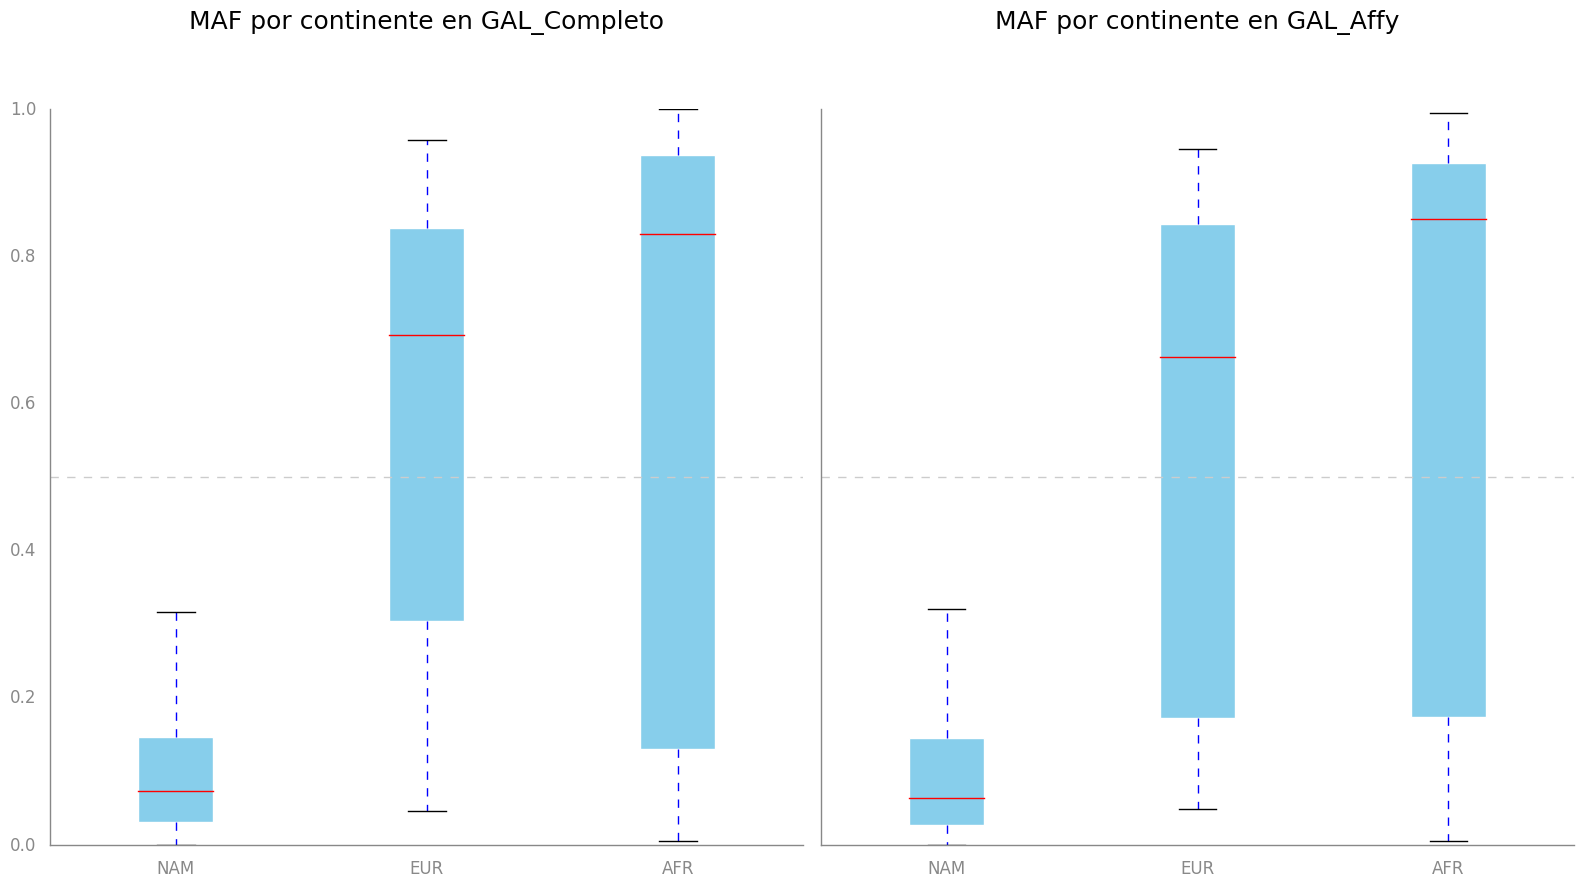

In [79]:
fig, axes = plt.subplots(1, 2, sharey=True)
titles = ("MAF por continente en GAL_Completo",
          "MAF por continente en GAL_Affy" )

for i, df in enumerate([galanter, present]):
    ax = axes[i]
    df = df.filter(["NAM_AF", "EUR_AF", "AFR_AF"])
    box = df.boxplot(ax=ax, rot=0, return_type='dict', patch_artist=True,
                     showfliers=False, figsize=(8, 3))
    
    for patch in box["boxes"]:
        patch.set_facecolor("skyblue")
        patch.set_edgecolor("white")

    ax.set_xticklabels(["NAM", "EUR", "AFR"])
    ax.set_title(titles[i], y=1.1)
    ax.set_ylim((0, 1))
    ax.axhline(0.5, color='#cccccc', linestyle='dashed')
    ax.grid(False)
    hide_spines_and_ticks(ax, spines=["top", "right"])
    
plt.tight_layout()
plt.show()

# No le da bola a figsize !?
### OJO!!! No son MAFs si son > .5 !!!!

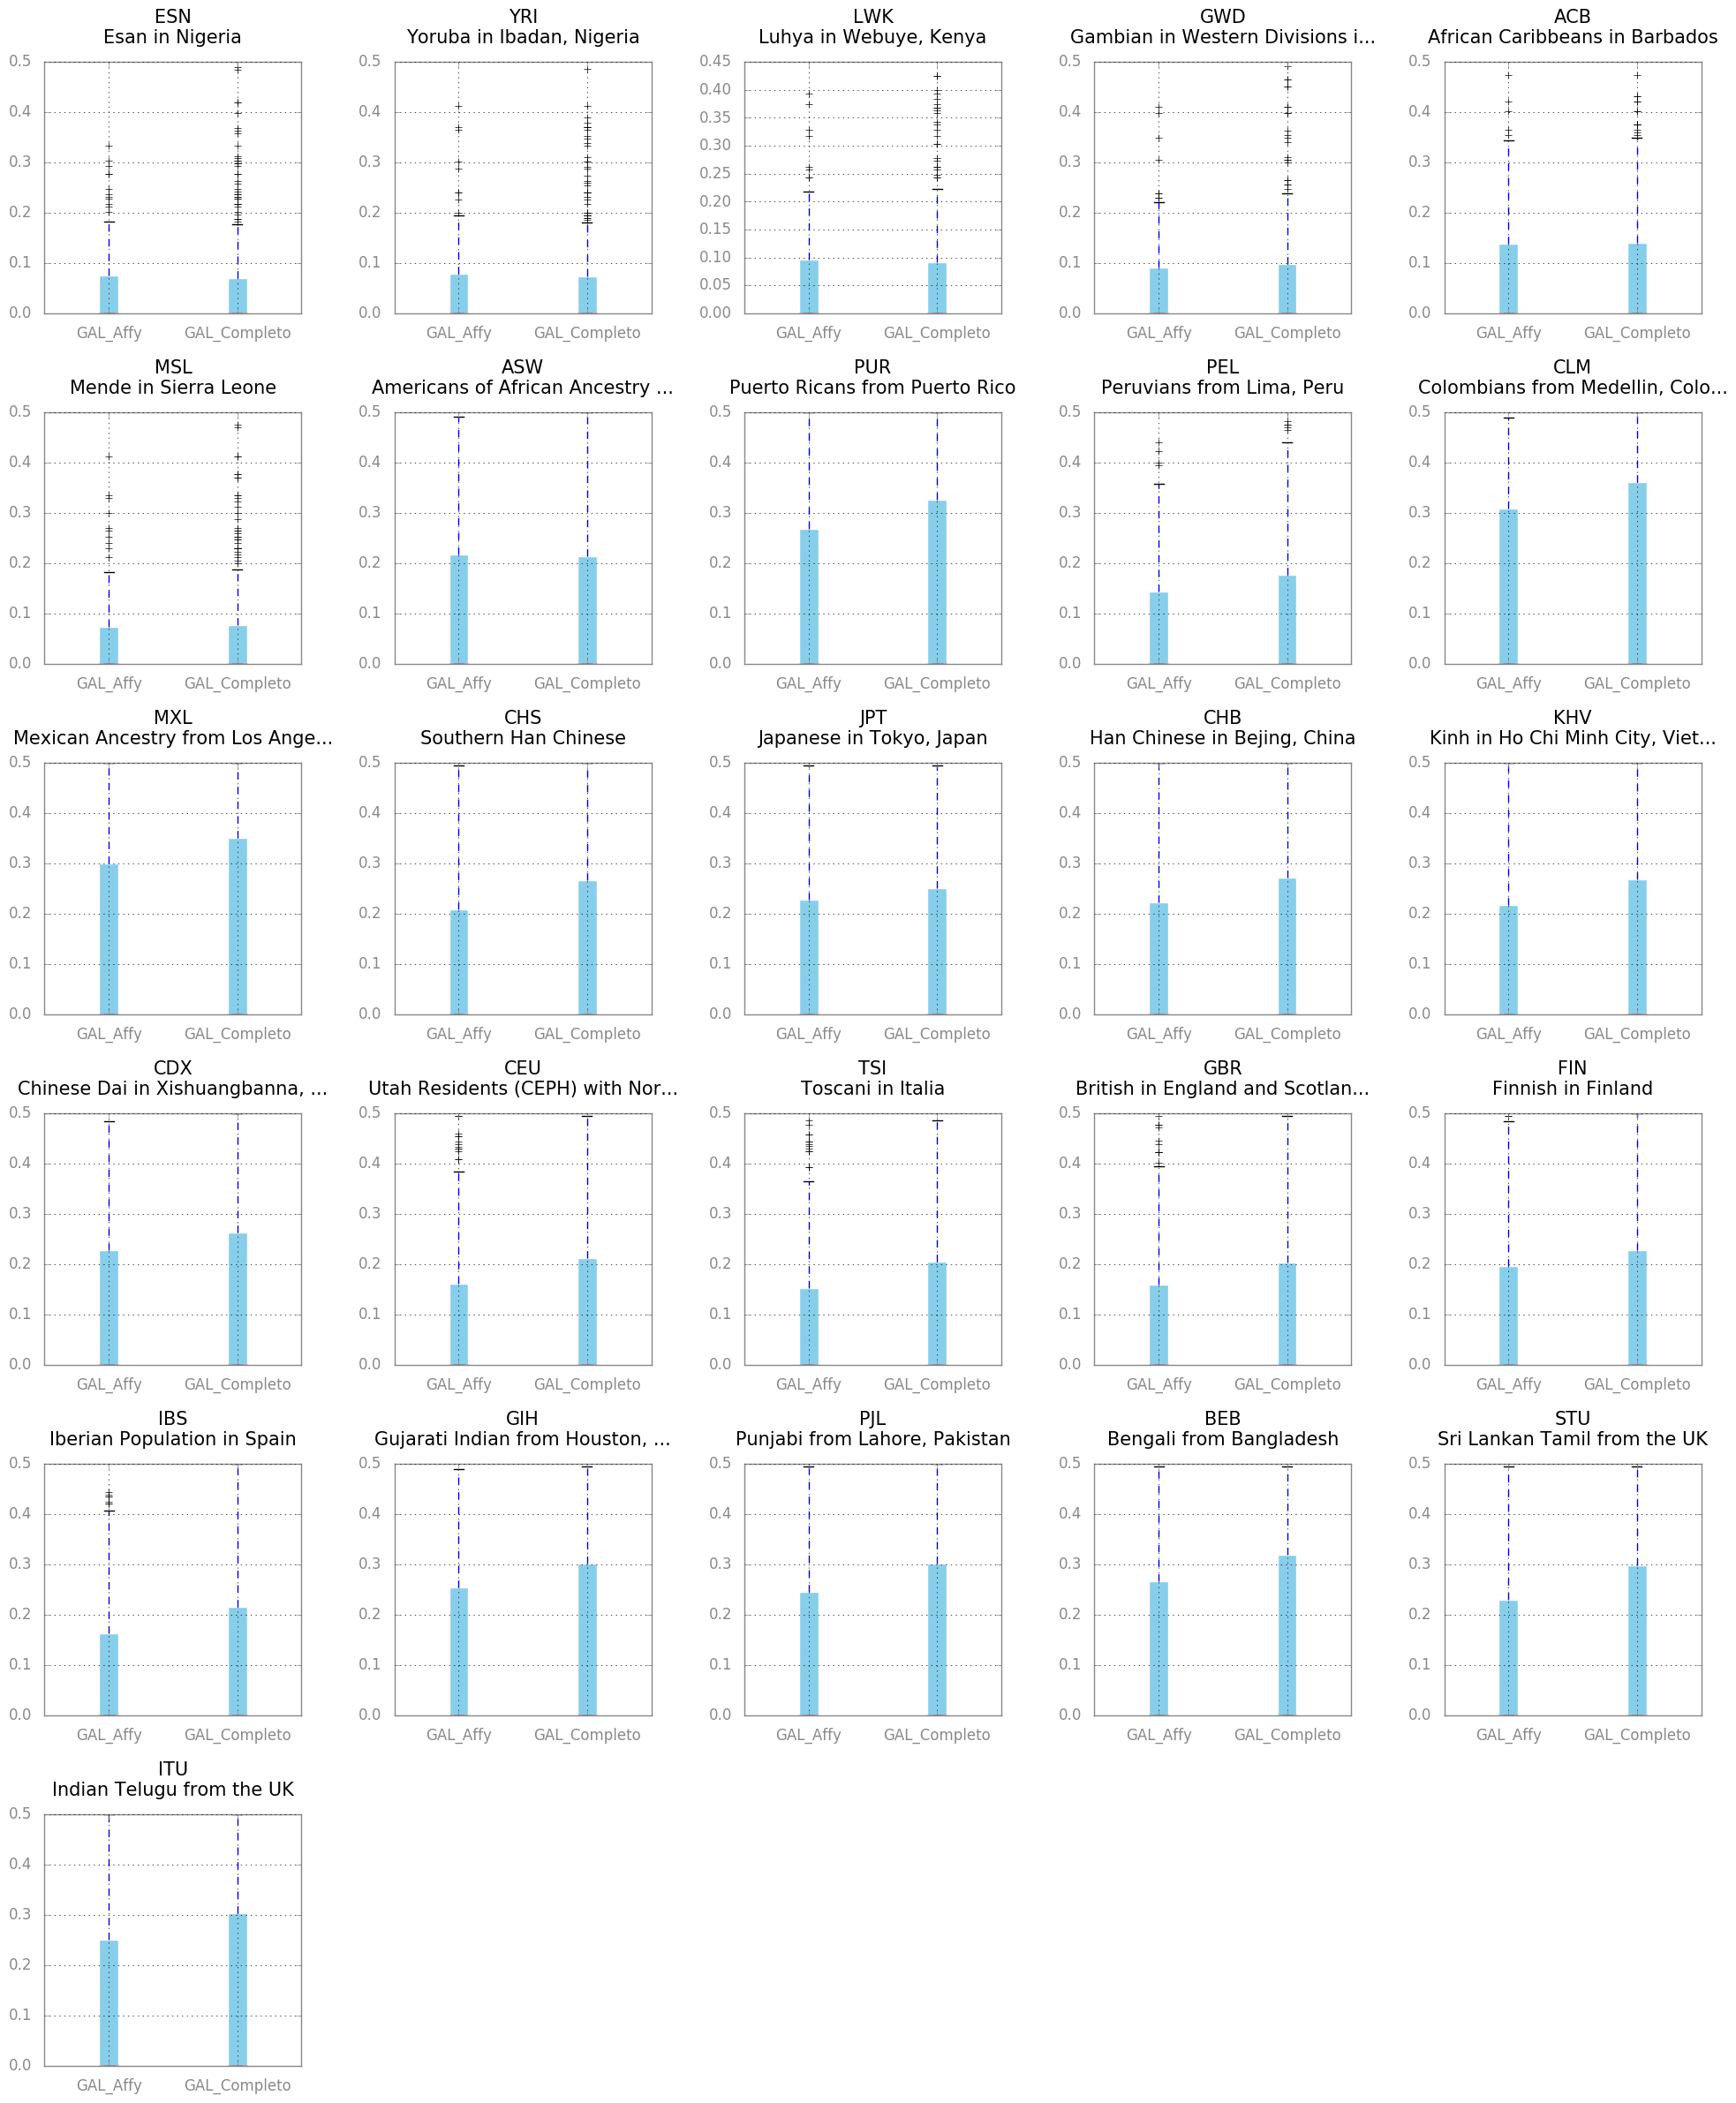

In [82]:
% run helpers/text_helpers.py

populations_to_plot = [p for p in df_1000G_sample_populations.sort_values('super_population')['population'].unique()]

get_freqs = lambda df: df.join(maf_1000G)[populations_to_plot]

chart_width = 4
chart_height = 4
fig_rows = 6
fig_cols = 5

fig = plt.figure(figsize=(fig_cols * chart_height, fig_rows * chart_width))

for i, population in enumerate(populations_to_plot):
    df = pd.DataFrame({"GAL_Affy": get_freqs(present)[population],
                       "GAL_Completo": get_freqs(galanter)[population]})

    ax = plt.subplot(fig_rows, fig_cols, i+1)
    pop_description = df_1000G_population_names.loc[population]['Population Description']
    ax.set_title(population + "\n" + trunc_text(pop_description, 30), y=1.05, fontsize=15)    
    box = df.boxplot(ax=ax, return_type='dict', patch_artist=True)
    for patch in box["boxes"]:
        patch.set_facecolor("skyblue")
        patch.set_edgecolor("white")
#     ax.set_ylim((0, 0.55))

plt.tight_layout()
plt.show()

In [83]:
mean_frequencies = lambda df: maf_1000G.loc[df.index].mean()
std_frequencies = lambda df: maf_1000G.loc[df.index].std()

In [84]:
import numpy as np
from collections import OrderedDict

df = pd.DataFrame(OrderedDict([
    ('$GAL_{Total}$', mean_frequencies(galanter)),
    ('$GAL_{Parcial}$', mean_frequencies(present)),
    ('Freq. Diff.', mean_frequencies(galanter) - mean_frequencies(present)),
]))

df = df.applymap(lambda n: round(n, 2))
freq_diff = df.join(df_1000G_population_names[['Population Description', 'Super Population Code']]).fillna('')
freq_diff = freq_diff.rename(columns={'Population Description': 'Population'})
freq_diff = freq_diff.drop('Super Population Code', axis=1)
freq_diff = freq_diff[freq_diff['Population'] != '']  # Removes superpopulations
freq_diff.sort_values(by='Freq. Diff.', ascending=False, inplace=True)

### Comparación de la "heterocigosidad"

In [85]:
# galanter_heter = galanter.join(df_1000G_SNPs, rsuffix='_').heterozygosity
# present_heter = present.join(df_1000G_SNPs, rsuffix='_').heterozygosity

# plt.figure(figsize=(5, 5))
# ax = plt.subplot(111)
# ax.boxplot([galanter_heter, present_heter])
# # ax.set_xticklabels(['$Galanter_{TOTAL}$', '$Galanetr_{IN}$'])
# # ax.set_ylim([0, .55])
# plt.show()

# Read the Control Random-Panels

In [86]:
# fn = "~/tesina/1000Genomes_data/control-panel-factor1/controlx1.parsed.traw"
# control_genotypes = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
# control_genotypes.index = [sample.split("_")[0] for sample in control_genotypes.index]

OSError: File b'/home/juan/tesina/1000Genomes_data/control-panel-factor1/controlx1.parsed.traw' does not exist

In [ ]:
# fn = "~/tesina/1000Genomes_data/control-panel-factor10/controlx10.parsed.traw"
# control_2_genotypes = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
# control_2_genotypes.index = [sample.split("_")[0] for sample in control_2_genotypes.index]

In [ ]:
# fn = "~/tesina/1000Genomes_data/control-panel-factor100/controlx100.parsed.traw"
# control_3_genotypes = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
# control_3_genotypes.index = [sample.split("_")[0] for sample in control_3_genotypes.index]

# Preparar datos para PCA y ADMIXTURE

In [ ]:
panel_indices = OrderedDict()
panel_indices["GAL Total\n443 SNPs"] = galanter.index
panel_indices["GAL Parcial\n170 SNPs"] = present.index
panel_indices["Panel Aleatorio x 1\n432 SNPs"] = control_genotypes.columns
panel_indices["Panel Aleatorio x 10\n4.078 SNPs"] = control_2_genotypes.columns
panel_indices["Panel Aleatorio x 100\n40.728 SNPs"] = control_3_genotypes.columns

# PCA

In [ ]:
import yaml

plot_colors = yaml.load(open("data/plot_colors.yml", "r"))
plot_markers = yaml.load(open("data/plot_markers.yml", "r"))

## Preparar datasets de muestras elegidas

In [ ]:
from collections import OrderedDict

samples = df_1000G_sample_populations

def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def indices(pop_dict):  
    populations = []
    for label, pop_list in pop_dict.items():
        mask = samples.population.isin(pop_list)
        populations.append(samples[mask])

    return pd.concat(populations).index

datasets_general = OrderedDict()
datasets_by_pop = OrderedDict()

all_latinos = {'latinos': ['PEL', 'MXL', 'CLM', 'PUR']}
e = {'europeans': ['IBS', 'TSI']}
ea = merge_dicts(e, {'africans': ['YRI', 'LWK']})
eac = merge_dicts(ea, {'east_asians': ['CHB', 'CHS']})
eaci = merge_dicts(eac, {'south_asians': ['GIH']})

datasets_general['Latinos'] = all_latinos
datasets_general['Latinos, Europeos'] = merge_dicts(e, all_latinos)
datasets_general['Latinos, Europeos, Africanos'] = merge_dicts(ea, all_latinos)
datasets_general['Latinos, Europeos, Africanos, Chinos'] = merge_dicts(eac, all_latinos)
datasets_general['Latinos, Europeos, Africanos, Chinos, Indios'] = merge_dicts(eaci, all_latinos)

# Transform population codes into dataframe indices (sample IDs)
# And write the sample IDs list to a file with the dataset name
for dataset_group in [datasets_general, datasets_by_pop]:
    for label, pop_dict in dataset_group.items():
        dataset_group[label] = indices(pop_dict)
        filename = "_".join(label.replace("\n", " ").split(", ")).lower()
        dataset_group[label].values.tofile("/home/juan/tesina/dataset_dumps/" + filename,
                                           sep="\n", format="%s")

In [ ]:
# Memory hog! Will eat ~2Gb RAM if control_3_genotypes is combined.
all_controls = control_genotypes.combine_first(control_2_genotypes).combine_first(control_3_genotypes)
all_controls.shape

In [ ]:
%run plot_PCAs.py

RUN_PCA = False

all_genotypes = df_1000G_genotypes.combine_first(all_controls)

for dataset_label, indices in datasets_general.items():
    if not RUN_PCA:
        continue

    genotypes = all_genotypes.loc[indices, :]
    
    pca = plot_PCAs(dataset_label, panel_indices, genotypes,
                    df_1000G_sample_populations,
                    plot_markers, plot_colors)

# Correr ADMIXTURE

In [ ]:
# panels_indices = {
#     "galT": galanter.index,
#     "galP": present.index,
#     "controlx1": control_genotypes.columns,
#     "controlx10": control_2_genotypes.columns,
#     "controlx100": control_3_genotypes.columns,
# }

# for panel_tag, panel_indices in panels_.items():
#     df_1000G_SNPs.index.intersection(panel_indices).values.tofile(
#         "~/tesina/admixture/{}.snps".format(panel_tag), sep="\n", format="%s"
#     )

* En `~/tesina/admixture/` están los archivos `*.samples` con los sample IDs de 1000Genomas de cada dataset (`L`, `LE`, `LEA` ...).
* En el mismo directorio copié los bfiles (`.bed`, `.bim` ...) de PLINK de cada panel (`galT`, `galP`, `controlx1`, `controlx10`, `controlx100`)
* Ahí mismo corrí `./create_datasets_run_admixture.sh <nombre-de-panel> <nombre-de-panel-2> ..`
* -> Se crean automáticamente directorios por cada combineta de dataset + panel con los archivos `*.P`

# Leer resultados de ADMIXTURE

## Plot CV Errors for different K values

In [ ]:
%%bash

# Generar el `CV_error_summary` que leo para los gráficos siguientes:

cd /home/juan/tesina/admixture
grep CV */*.log > CV_error_summary
cat CV_error_summary | sed s'#[/:)]#,#g' | sed s'/CV error (K=//g' | awk -F, '{OFS=","; print $1, $3, $5}' | sed s'/, /,/g' > CV_error_summary.clean
cd /home/juan/tesina/notebook

In [ ]:
dataset_names = {
    "L": "Latinos",
    "LE": "Latinos, Europeos",
    "LEA": "Latinos, Europeos, Africanos",
    "LEAC": "Latinos, Europeos,\nAfricanos, Chinos",
    "LEACI": "Latinos, Europeos,\nAfricanos, Chinos, Indios"
}

panel_names = {
    "galP": "GAL Parcial (170 SNPs)",
    "galT": "GAL Total (443 SNPs)",
    "controlx1": "Panel Aleatorio x 1 (432 SNPs)",
    "controlx10": "Panel Aleatorio x 10 (4.078 SNPs)",
    "controlx100": "Panel Aleatorio x 100 (40.728 SNPs)",
}

In [ ]:
from itertools import product


plot_panel_colors = {
    "galP": "Tomato",
    "galT": "CornflowerBlue",
#     "controlx1": "#555555",
#     "controlx10": "#666666",
#     "controlx100": "#777777",
}

cv_errors = pd.read_csv("~/tesina/admixture/CV_error_summary.clean",
                        names=['dataset_panel', 'K', 'CV_error'])

cv_errors['dataset'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[0])
cv_errors['panel'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[1])
cv_errors = cv_errors.drop('dataset_panel', axis=1)
cv_errors = cv_errors.set_index(['dataset', 'panel', 'K']).sort_index()


Ks = cv_errors.index.get_level_values('K').unique()

width, height = (5, 3)
cols, rows = (2, 3)
fig = plt.figure(figsize=(width * cols, height * rows))
axes = list(np.arange(cols * rows) + 1)
axes.reverse()

datasets = cv_errors.index.get_level_values('dataset').unique()
for dataset in datasets:
    
    ax = plt.subplot(rows, cols, axes.pop())
    lines = []
    
    panels = cv_errors.loc[dataset].index.get_level_values('panel').unique()
    panels = [panel for panel in panels if "gal" in panel]  # Filter out the control panels for this chart
    for panel in panels:
        data = cv_errors.loc[(dataset, panel)]            
        data.plot(ax=ax, marker=".", color=plot_panel_colors[panel], zorder=1)
        
        x_min = data['CV_error'].idxmin()
        y_min = data['CV_error'].min()
        min_marker = ax.scatter(x_min, y_min, marker="v", color="DarkGreen", zorder=2, s=35)
        
        # TODO: Add a special mark at the minimum y value
    
    lines, labels = ax.get_legend_handles_labels()
    panel_labels = [panel_names[panel] for panel in panels]
    ax.set_title("Dataset: " + dataset_names[dataset], fontsize=12)
    ax.set_ylabel("CV Error", fontsize=11)
    ax.set_xlabel("K", fontsize=11)
    ax.legend_.remove()

# Ugly hack to get the legend in a separate subplot slot
ax = plt.subplot(rows, cols, axes.pop())
ax.legend(lines + [min_marker], panel_labels + ['Valor óptimo de K'],
          fontsize=13, loc='upper left', fancybox=True, scatterpoints=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
for loc in ['top', 'bottom', 'left', 'right']:
    ax.spines[loc].set_visible(False)

plt.tight_layout()
plt.show()

## Plot ADMIXTURE ancestry ratios per individual

In [ ]:
from collections import OrderedDict
from collections import defaultdict


dataset_Ks = OrderedDict([("L", 3), ("LE", 3), ("LEA", 3), ("LEAC", 4), ("LEACI", 5)])
panels = ["galT", "galP", "controlx1", "controlx10", "controlx100"]
admixture_results = defaultdict(OrderedDict)
ancestral_components = {0: 'EUR', 1: 'NAM', 2: 'AFR', 3: 'EAS', 4: 'SAS'}

population_groups = OrderedDict([
    ('Latinos',   ['CLM', 'MXL', 'PEL', 'PUR']),
    ('Europeos',  ['TSI', 'IBS']),
    ('Africanos', ['LWK', 'YRI']),
    ('Chinos',    ['CHS', 'CHB']),
    ('Indios',    ['GIH'])
])

In [ ]:
for dataset_tag, optimal_K in dataset_Ks.items():
    for panel_tag in panels:
        fdir = "~/tesina/admixture/{}_{}/".format(dataset_tag, panel_tag)
        filename = "{}_{}.{}.Q".format(dataset_tag, panel_tag, optimal_K)
        samples_filename = "{}_{}.fam".format(dataset_tag, panel_tag)
        ancestry_values = pd.read_csv(fdir + filename, sep="\s+",
                                      names=list(range(optimal_K)))
        sample_ids = pd.read_csv(fdir + samples_filename, sep="\s+",
                                 index_col=0, usecols=[0], names=['sample_id'])
        ancestry_values['sample_id'] = sample_ids.index
        populations = df_1000G_sample_populations.loc[sample_ids.index]['population']
        ancestry_values['population'] = populations.values
        ancestry_values['super_population'] = [df_1000G_population_names.loc[population]['Super Population Code']
                                               for population in populations.values]

        # Reorder ancestry columns to always have the same ancestral populations
        # in the same positions (and then the same order and colors in the plots).
        # Desired order: European, Amerindian, African, Chinese, Indian
        # This is necessarily hardcoded after visual inspection of the plots.
        fixed_columns = ['sample_id', 'population', 'super_population']
        if panel_tag == "galT":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[1, 3, 2, 0] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[3, 0, 2, 1, 4] + fixed_columns]
        if panel_tag == "galP":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 1, 0, 2] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[3, 0, 2, 1, 4] + fixed_columns]
        if panel_tag == "controlx1":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[1, 0, 2] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 0, 2, 1] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[4, 0, 2, 3, 1] + fixed_columns]
        if panel_tag == "controlx10":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 0, 2, 1] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[4, 0, 2, 3, 1] + fixed_columns]
        if panel_tag == "controlx100":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[1, 0, 2] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 0, 2, 1] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[4, 0, 2, 3, 1] + fixed_columns]
                
        # Reassign the column numbers
        columns_renumbered = list(range(len(ancestry_values.columns) - len(fixed_columns)))
        ancestry_values.columns = (columns_renumbered + fixed_columns)
        
        # Replace the numbers with the continental population codes
        # This naming of the ancestry columns only makes sense with the previous ordering,
        # which placed the components in the same order as the one in "ancestral_components"
        renamed_columns = [ancestral_components[n] for n in ancestry_values.columns
                          if n not in fixed_columns]
        ancestry_values.columns = renamed_columns + fixed_columns
        
        # Reorder the named columns
        ancestral_components_ordered = list(ancestral_components.values())[:len(renamed_columns)]
        ancestry_values = ancestry_values[ancestral_components_ordered + fixed_columns]

        # Sort the samples
        ancestry_values = ancestry_values.sort_values(['super_population', 'population', 'EUR'])
        ancestry_values = ancestry_values.reset_index(drop=True)

        admixture_results[dataset_tag][panel_tag] = ancestry_values

In [ ]:
from collections import OrderedDict


def config_admixture_plot(ax, df, ylabel_on=True):
    ax.set_title(panel_name, fontsize=14, position=(0.5, 1.4))
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Set population names on the xticks
    indices_by_population = [df[df['population'] == population].index.values
                             for population in df['population'].unique()]
    xtick_positions = [np.median(indices) for indices in indices_by_population]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(df['population'].unique(), rotation=0)
    ax.xaxis.set_ticks_position("top")

    # Separate the populations with a line
    
    separation_lines = [max(indices) for indices in indices_by_population]
    [plt.axvline(x=x, color="k", lw=1) for x in separation_lines[:-1]]

    if ylabel_on:
        ax.set_ylabel("Proporción de\nancestrías", fontsize=11)
        
    ax.set_ylim((0, 1))
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.legend().set_visible(False)

    return ax

for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
        
    # One figure per panel per dataset on top
    
    rows = len(panels)
    fig = plt.figure(figsize=(12, 2 * rows))
    axes = (np.arange(len(panels)) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
        ax = plt.subplot(rows, 1, axes.pop())
        df.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
        ax = config_admixture_plot(ax, df)
    
    plt.tight_layout()
    
    title = "Dataset: {} ($K={}$)".format(dataset_name, K)
    fig.suptitle(title, fontsize=17)
    plt.subplots_adjust(top=(0.75))  # Make space for the fig.suptitle
    
    plt.show()
    
#     # Detail plots for each population group
    
#     # Detail plots dimensions and subplot number generation
#     width, height = (6, 2)
    
#     # Hacky! Dataset tags are acronyms of the population groups
#     # So I'm inferring the number of population group from the length of the tag.
#     cols, rows = (2, len(dataset_tag))  # One row of plots per population group
    
#     if dataset_tag == "L":
#         rows = len(population_groups["Latinos"])
    
#     fig = plt.figure(figsize=(width * cols, height * rows))

#     odd_subplots = [n for n in np.arange(rows * cols) + 1 if n % 2 != 0]
#     even_subplots = list(np.array(odd_subplots) + 1)
#     axes = {"galT": odd_subplots[::-1], "galP": even_subplots[::-1]}

#     sorted_index = []  # Hack. See (1) below.

#     # One subplot per population group per panel in the dataset
#     for panel_tag, df in panel_results.items():
#         panel_name = panel_names[panel_tag]
        
#         if dataset_tag == "L":
#             # Hack to get one plot per latino population in this dataset
#             pg = dict([(p, [p]) for p in population_groups["Latinos"]])
#         else:
#             pg = population_groups
            
#         for population_group_name, population_group in pg.items():
#             mask = df['population'].isin(population_group)
#             df_pop = df[mask].dropna()
#             if len(df_pop) == 0:
#                 continue
    
#             # (1) Hack to get the same sample order in both columns of plots
#             if panel_tag == "galT":
#                 sorted_index = [df_pop.index] + sorted_index
#             elif panel_tag == "galP":
#                 df_pop = df_pop.loc[sorted_index.pop()]

#             # I need consecutive indices for the xtick labels position calculation later:
#             df_pop = df_pop.reset_index(drop=True)
            
#             ax_id = axes[panel_tag].pop()
#             ax = plt.subplot(rows, cols, ax_id)
#             df_pop.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
            
#             ylabel_on = (ax_id % 2 != 0)  # Y-axis label only on plots on the left (odd plots)
#             title_on = (ax_id in [1, 2])  # Only top plots carry the panel_name as title

#             ax = config_admixture_plot(ax, df_pop, ylabel_on=ylabel_on)

#     plt.tight_layout()
#     plt.show()

In [ ]:
def get_superpop_from_poptag(tag):
    ref = df_1000G_population_names

    if tag not in ref.index:
        return tag
    
    return ref.loc[tag]['Super Population Code']

def config_admixture_mean_plot(ax, df, title=None, ylabel_on=True):
    if title:
        ax.set_title(title, fontsize=12.5, fontweight="bold")

#     if ylabel_on:
#         ax.set_ylabel("Proporción de\nancestrías", fontsize=11)

    ax.set_ylim((-0.05, 1.05))
    ax.set_yticks([])
    
    xticklabels = plt.xticks()[1]
    xticks_rot = 0 if len(xticklabels) < 10 else 45
    ax.set_xticklabels(xticklabels, rotation=xticks_rot)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel("")
    ax.set_frame_on(False)
    ax.legend_.remove()

    return ax


for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
    
    rows, cols = len(panel_results.keys()), 1
    fig = plt.figure(figsize=(cols * width, rows * height))
    axes = (np.arange(rows * cols) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        
        panel_name = panel_names[panel_tag]
        ax_id = axes.pop()
        ax = plt.subplot(rows, cols, ax_id)
        
        by_population = df.groupby("population").mean()
        # by_superpopulation = df.groupby("super_population").mean()
        # both = pd.concat([by_population, by_superpopulation])

        by_population["superpop"] = [get_superpop_from_poptag(ix)
                                     for ix in by_population.index.values]
        by_population = by_population.sort_values(["superpop", "EUR"])
        
        by_population.plot(ax=ax, kind="bar", stacked=True, width=1, lw=0.35, rot=0)
        config_admixture_mean_plot(ax, by_population, title=panel_name, ylabel_on=True)
    
    figtitle = "{} (K={})".format(dataset_name, K)
    fig.suptitle(figtitle, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(top=(0.90))
    plt.show()

## Triangular plot or 3D plot with the K=3 values

In [ ]:
import ternary


for dataset_tag, panel_results in admixture_results.items():
    if len(dataset_tag) > 3:
        continue
    
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
    
    rows, cols = 1, len(panels)
    width, height = 10, 8
    fig = plt.figure(figsize=(cols * width, rows * height))

    axes = (np.arange(rows * cols) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
            
        ax_id = axes.pop()
        ax = plt.subplot(rows, cols, ax_id)
        ax.axis("off")
        fig, tax = ternary.figure(scale=1, ax=ax)

        for population in df['population'].unique():
            mask = df['population'] == population
            tax.scatter(df[mask].iloc[:, :3].as_matrix(), label=population,
                        color=plot_colors[population], marker=plot_markers[population])

        tax.set_title("Dataset: {}\n{}".format(dataset_name, panel_name),
                      position=(0.5, 1.05))

        tax.boundary(linewidth=1)

        fontsize = 15
        tax.left_axis_label(df.columns[2], fontsize=fontsize)
        tax.bottom_axis_label(df.columns[0], fontsize=fontsize)
        tax.right_axis_label(df.columns[1], fontsize=fontsize)

        tax.ticks(axis="lbr", linewidth=1, multiple=0.1)
        tax.gridlines(multiple=0.1)
        tax.legend(frameon=False, fontsize=12, scatterpoints=1)

        tax.clear_matplotlib_ticks()

    plt.show()

# Read HDGP markers

Para descargar los datos de HGDP usé ftp_download_HGDP.py

## CEPH dataset

In [ ]:
fn = "~/tesina/HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-marker.out"
hgdp_ceph_markers = pd.read_csv(fn, sep="\t")
hgdp_ceph_markers = hgdp_ceph_markers.rename(columns={"chrom": "chr", "physical_pos": "pos"})
mask = hgdp_ceph_markers["type_marker"].isin(["SNP", "snp"])
hgdp_ceph_markers = hgdp_ceph_markers[mask].reset_index(drop=True)

In [ ]:
fn = "~/tesina/HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-geno.out"
# Filter only biallelic SNPs!
hgdp_ceph_genotypes = pd.read_csv(fn, sep="\t", index_col="hgdp_id")
hgdp_ceph_genotypes.head(2)

In [ ]:
# Filtrar esos 5,4 M de genotipos por el mkr_ceph_id de los rs de galanter
# ojo con la RAM!

## Stanford dataset

In [ ]:
fn = "~/tesina/HGDP_data/dataset_2_supp1_Stanford/hgdp/HGDP_Map.txt"
hgdp_stanford_markers = pd.read_csv(fn, sep="\t", names=["dbsnp_id", "chr", "pos"],
                                    index_col="dbsnp_id")

## Uni of Michigan dataset

In [ ]:
from glob import glob
from os.path import isfile

dumpfile = "./dumpfiles/HGDP_michigan_markers.csv"

if isfile(dumpfile):
    dtypes = {"dbsnp_id": str, "chr": str, "pos_build_36": int, "pos_build_35": int}
    hgdp_michigan_markers = pd.read_csv(dumpfile, index_col="dbsnp_id", dtype=dtypes)
else:    
    markers_per_chr = []
    
    # The *.map files were generated with "parse_HGDP_UMichigan_data.sh"
    for fn in glob("~/tesina/HGDP_data/dataset_3_supp2_UMichigan/GENO/chr*.map"):
        markers_per_chr.append(pd.read_csv(fn, sep="\s+").transpose())

    hgdp_michigan_markers = pd.concat(markers_per_chr).drop(0, axis=1)
    hgdp_michigan_markers.columns = ["chr", "pos_build_36", "pos_build_35"]
    hgdp_michigan_markers["pos"] = hgdp_michigan_markers["pos_build_36"]
    hgdp_michigan_markers.index.name = "dbsnp_id"
    hgdp_michigan_markers.to_csv(dumpfile)

## Max Plank Institute datset

In [ ]:
fn = "~/tesina/HGDP_data/dataset_4_supp3_MPlank/hgdpceph.affy500k.map.gz"
hgdp_maxplank_markers = pd.read_csv(fn, sep="\t", names=["chr", "dbsnp_id", "?", "pos"],
                                    usecols=["chr", "dbsnp_id", "pos"], index_col="dbsnp_id")

## Harvard dataset

In [ ]:
fn = "~/tesina/HGDP_data/dataset_11_supp10_Harvard/Harvard_HGDP-CEPH/all_snp.map.gz"
hgdp_harvard_markers = pd.read_csv(fn, sep="\t", names=["chr", "Affy SNP ID", "?", "pos"],
                                   usecols=["chr", "Affy SNP ID", "pos"])

fn = "~/tesina/HGDP_data/dataset_11_supp10_Harvard/Axiom_GW_HuOrigin.na35.annot.csv.tar.gz"
affy_human_origins = pd.read_csv(fn, comment="#", skiprows=1, index_col="Affy SNP ID",
                                 usecols=["Affy SNP ID", "dbSNP RS ID"])

hgdp_harvard_markers = hgdp_harvard_markers.set_index("Affy SNP ID")
hgdp_harvard_markers = hgdp_harvard_markers.join(affy_human_origins)
hgdp_harvard_markers = hgdp_harvard_markers.rename(columns={"dbSNP RS ID": "dbsnp_id"})

## UCLA dataset

In [ ]:
fn = "~/tesina/HGDP_data/dataset_15_supp15_UCLA/snp_info.csv"
hgdp_ucla_markers = pd.read_csv(fn, names=["_", "_", "chr", "pos", "dbsnp_id"],
                                usecols=["chr", "pos", "dbsnp_id"], skiprows=1).dropna()

## Intersection GAL x HGDP

In [ ]:
hgdp_panels = {
    "CEPH": hgdp_ceph_markers,
    "Stanford": hgdp_stanford_markers,
    "MaxPlank": hgdp_maxplank_markers,
    "Harvard": hgdp_harvard_markers,
    "UCLA": hgdp_ucla_markers,
    "UMichigan": hgdp_michigan_markers,
}

In [ ]:
galanter_HGDP_matches = pd.DataFrame({"dbsnp_id": galanter.index})
galanter_HGDP_matches = galanter_HGDP_matches.set_index("dbsnp_id")

for panel_name, markers in hgdp_panels.items():
    print(panel_name, len(markers))
    galanter_HGDP_matches[panel_name] = \
        galanter_HGDP_matches.index.map(lambda x: x in markers.index.values)

galanter_HGDP_matches["hits"] = galanter_HGDP_matches.sum(axis=1)

In [ ]:
galanter_hgdp_indices = {}

print("Galanter Matches in HGDP panels:")
for hgdp_panel_name, markers in hgdp_panels.items():
    matches = galanter_HGDP_matches[hgdp_panel_name]
    intersection_count = len(matches[matches])
    
    if intersection_count > 0:
        galanter_hgdp_indices[hgdp_panel_name] = {}
        galanter_hgdp_indices[hgdp_panel_name]["galT"] = galanter_HGDP_matches[matches].index
        galanter_hgdp_indices[hgdp_panel_name]["galP"] = \
            galanter_HGDP_matches[matches].loc[present.index].dropna(axis=0).index
        
        print("-")
        print(hgdp_panel_name, "galT ->",
              len(galanter_hgdp_indices[hgdp_panel_name]["galT"]))
        print(hgdp_panel_name, "galP ->",
              len(galanter_hgdp_indices[hgdp_panel_name]["galP"]))

# HGDP populations

In [ ]:
hgdp_continents = {
    "Asia": "ASN",
    "Subsaharian Africa": "AFR",
    "Oceania": "EAS",
    "Europe": "EUR",
    "Middle Est": "WAS",
    "America": "AMR",
    "North Africa": "AFR",
}

### CEPH populations

In [ ]:
fn = "~/tesina/HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-pop.out"
usecols = ["population_name", "population_id", "nickname"]
hgdp_populations_detail = pd.read_csv(fn, sep="\t", usecols=usecols)
hgdp_populations_detail.set_index("population_name", inplace=True)

In [ ]:
popcodes = dict(zip(hgdp_populations_detail.index.values,
                    hgdp_populations_detail["nickname"].values))

In [ ]:
fn = "~/tesina/HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-unrelated.out"
hgdp_samples = pd.read_csv(fn, sep="\t", index_col="hgdp_id")
hgdp_samples["continent"] = hgdp_samples["Region"].map(hgdp_continents)
hgdp_samples["population_name"] = hgdp_samples["population"]
hgdp_samples["population"] = hgdp_samples["population_name"].map(popcodes)

In [ ]:
regions = dict(zip(hgdp_samples["population_name"],
                   hgdp_samples["Region"]))
continents = dict(zip(hgdp_samples["population_name"],
                      hgdp_samples["continent"]))

In [ ]:
hgdp_populations_detail["continent"] = \
    hgdp_populations_detail.index.map(lambda x: continents[x])
hgdp_populations_detail["region"] = \
    hgdp_populations_detail.index.map(lambda x: regions[x])

### MaxPlank populations

In [ ]:
corrections = {
    "Colombian": "Colombians",
    "Cambodian": "Cambodians",
    "MbutiPygmy": "Mbuti_Pygmies",
    "NewGuinea": "Papuan",
}

superpops = {
    "Nasioi": "EAS",
    "BiakaPygmy": "AFR",
    "Bantu": "AFR",
    "Basque": "EUR",
    "Bergamo": "EUR",
}

def fix_popnames(popname):
    if popname not in corrections.keys():
        return popname
    
    return corrections[popname]

def get_superpop(popname):
    if popname in hgdp_populations_detail.index:
        return hgdp_populations_detail.loc[popname]["continent"]

    if popname in superpops.keys():
        return superpops[popname]
    
    return "Unknown"

In [ ]:
fn = "~/tesina/HGDP_data/dataset_4_supp3_MPlank/hgdpceph.affy500k.pedind"
mplank_populations = pd.read_csv(fn, sep="\s+",
                                 names=[".", "sample", ".", ".", ".", "population"],
                                 usecols=["sample", "population"])
mplank_populations.set_index("sample", inplace=True)
mplank_populations["population"] = mplank_populations["population"].map(fix_popnames)
mplank_populations["continent"] = mplank_populations["population"].map(get_superpop)

# HGDP genotypes and populations read

In [ ]:
hgdp_genotypes = defaultdict(OrderedDict)

## MaxPlank dataset

In [ ]:
fn = "~/tesina/HGDP_data/dataset_4_supp3_MPlank/hgdpceph.affy500k.AT.traw.parsed"
df = pd.read_csv(fn, sep="\s+")
renamed_columns = [s.split("_")[-1] for s in df.columns]
df.columns = renamed_columns
df.rename(columns={"SNP": "dbsnp_id"}, inplace=True)
df.set_index("dbsnp_id", inplace=True)

for panel_name in panels:
    indices = galanter_hgdp_indices["MaxPlank"][panel_name]
    hgdp_genotypes["MaxPlank"][panel_name] = df.loc[indices]

df = None # Hope this cleans the big dataframe from memory?

In [ ]:
latinos = ['Colombians', 'Karitiana', 'Maya', 'Surui', 'Pima']
europeans = ['Basque', 'Bergamo', 'French']
africans = ['BiakaPygmy' 'Bantu', 'Mandenka']
middle_eastern = ['Balochi', 'Bedouin', 'Brahui', 'Mongola']
oceania = ['Papuan']
east_asian = ['Dai']

LEA_populations = latinos + africans + europeans
world_populations = LEA_populations + middle_eastern + oceania

datasets_mplank = OrderedDict()
dataset_definitions = {
    "MaxPlank LEA": LEA_populations,
    "MaxPlank World": world_populations,
}

for dataset_label, population_list in dataset_definitions.items():
    mask = mplank_populations["population"].isin(population_list)
    sample_indices = mplank_populations[mask].index
    dataset = hgdp_genotypes["MaxPlank"]["galT"].loc[:, sample_indices].transpose()
    datasets_mplank[dataset_label] = dataset

In [ ]:
% run plot_PCAs.py

hgdp_panel_name = "MaxPlank"

panel_indices = OrderedDict()
panel_indices['GAL Total'] = galanter.index
panel_indices['GAL Parcial'] = present.index

for dataset_label, dataset in datasets_mplank.items():
    pca = plot_PCAs(dataset_label, panel_indices, dataset,
                    mplank_populations, plot_markers, plot_colors)